# DEA STAC Query with Grid Tiles
## Sentinel 2

In [1]:
import math

import pystac_client
import odc.stac

from datacube.utils.geometry import CRS, box, GeoBox, Geometry
from datacube.model import GridSpec

In [2]:
########################################################################################
## calc_odcstac_bbox
########################################################################################
# Calculate square bounding box coordinates given SW corner and distance in metres of 
# horizontal and vertical extent of tile.
# coords are specified in the following order [ longitude, latitude ]
# extent is specified in the following order [ horizontalextent(m), verticalextent(m)]
# bbox returns [min(lon), min(lat), max(lon), max(lat)]
#
# Adapted from sourcecode located at ref: https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing

def calc_gridbbox(coords, extent, crs):
    R = 6371000 # Radius of the Earth in m
    
    hbearing = math.radians(90) # bearing from true north for calculating 2nd longitude value
    vbearing = math.radians(0) # bearing from true north for calculating 2nd latitude value
    
    lat1 = math.radians(coords[1])
    lon1 = math.radians(coords[0])
    
    hd= extent[0] # horizontal extent/distance in metres
    vd= extent[1] # vertical extent/distance in metres
    
    lat2 = math.asin( math.sin(lat1)*math.cos(vd/R)
                     + math.cos(lat1)*math.sin(vd/R)*math.cos(vbearing))
    
    lon2 = lon1 + math.atan2(math.sin(hbearing)*math.sin(hd/R)*math.cos(lat1),
                             math.cos(hd/R)-math.sin(lat1)*math.sin(lat2))

    gridbbox = box(coords[0], math.degrees(lon2), coords[1], math.degrees(lat2), crs)
    bbox = [coords[0],  coords[1], math.degrees(lon2), math.degrees(lat2)]
    return gridbbox, bbox

### DEA Open Data Cube Query Parameters (Constants)

In [3]:
# Area North East of Mallala,SA
surveyarea_SW = ( 138.43623157814235, -34.48646411817517) # bottom left (South West) corner of Survey area
surveyarea_origin = surveyarea_SW[::-1]

# Survey Area (Region of Interest)
epsg3577 = 'EPSG:3577'            # EPSG:3577: GDA94 / Australian Albers projection
pixel_resolution = (-10,10)       # Each pixel is of 10m x 10m resolution
surveyarea_extent = (20480,20480) # boundary of full survey area  (in metres)
survey_tilesize = (5120,5120)      # size of each tile in the survey area (in metres)

# Date Range
start_date = "2022-04-22"
end_date = "2022-04-26"

# Satellite datasets
collections = ["s2a_ard_granule", "s2b_ard_granule"] # Sentinel-2A and 2B MSI Definitive ARD - NBART and Pixel Quality

# Satellite Bands
bands_to_load = ("nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1")

### Define Survey Area Grid Tiles

In [4]:
# Define Grid Specification for a specific CRS, tile size and pixel resolution
survey_grid = GridSpec( crs=CRS(epsg3577), 
                        tile_size=survey_tilesize, 
                        resolution=pixel_resolution,
                        origin=(0.0,0.0))
print(survey_grid)
print(survey_grid.alignment)
print(survey_grid.dimensions)
print(survey_grid.tile_resolution)

GridSpec(crs=EPSG:3577, tile_size=(5120, 5120), resolution=(-10, 10))
(0.0, 0.0)
('y', 'x')
(512, 512)


In [5]:
# Apply Grid to Survey Area
surveyarea_region, sae_bbox = calc_gridbbox(coords=surveyarea_SW, extent=surveyarea_extent, crs=epsg3577)

In [6]:
# Display Grid Tile offsets for Survey Area
list(survey_grid.tiles(surveyarea_region.boundingbox))

[((-1, -1),
  GeoBox(512, 512, Affine(10.0, 0.0, -5120.0,
         0.0, -10.0, 0.0), EPSG:3577)),
 ((0, -1),
  GeoBox(512, 512, Affine(10.0, 0.0, 0.0,
         0.0, -10.0, 0.0), EPSG:3577)),
 ((-1, 0),
  GeoBox(512, 512, Affine(10.0, 0.0, -5120.0,
         0.0, -10.0, 5120.0), EPSG:3577)),
 ((0, 0),
  GeoBox(512, 512, Affine(10.0, 0.0, 0.0,
         0.0, -10.0, 5120.0), EPSG:3577))]

### Get Catalog metadata

In [7]:
catalog = pystac_client.Client.open('https://explorer.sandbox.dea.ga.gov.au/stac')

In [8]:
# Build a query with the set parameters
query = catalog.search(
    bbox=sae_bbox,
    collections=collections,
    datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 4 datasets


In [9]:
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
import os
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [10]:
ds = odc.stac.load(
    items,
    bands=bands_to_load,
    crs=epsg3577,
    resolution=pixel_resolution,
    chunks={},
    groupby="solar_day",
    bbox=sae_bbox,
)

In [11]:
ds.nbart_nir_1

<xarray.DataArray 'nbart_nir_1' (time: 2, y: 2155, x: 2145)>
dask.array<dc_load_nbart_nir_1, shape=(2, 2155, 2145), dtype=uint16, chunksize=(1, 2155, 2145), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-04-24T00:56:35.619528 2022-04-26T...
  * y            (y) float64 -3.759e+06 -3.759e+06 ... -3.781e+06 -3.781e+06
  * x            (x) float64 5.885e+05 5.886e+05 5.886e+05 ... 6.1e+05 6.1e+05
    spatial_ref  int32 3577
Attributes:
    nodata:        0
    units:         1
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

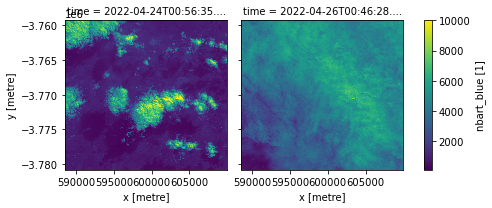

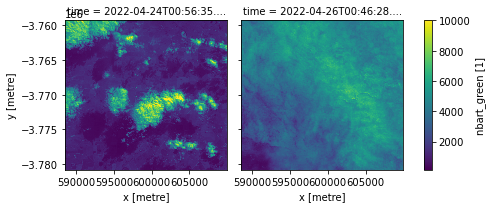

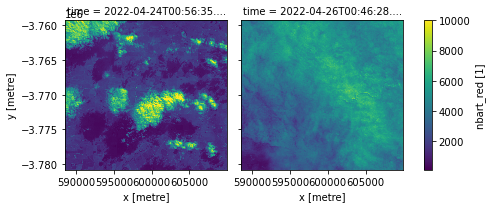

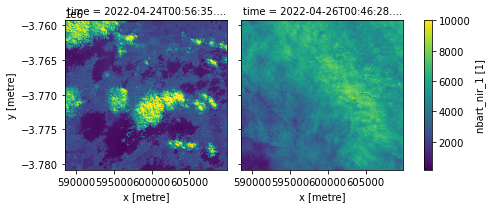

In [12]:
# refer to https://xarray.pydata.org/en/stable/generated/xarray.plot.plot.html?highlight=plot
# to tweak plots
ds.nbart_blue.plot(col='time', aspect=ds.dims["x"] / ds.dims["y"]);
ds.nbart_green.plot(col='time', aspect=ds.dims["x"] / ds.dims["y"]);
ds.nbart_red.plot(col='time', aspect=ds.dims["x"] / ds.dims["y"]);
ds.nbart_nir_1.plot(col='time', aspect=ds.dims["x"] / ds.dims["y"]);